<a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_monitoring/model_monitoring.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 16FlYMaze : Analysis of Gr64f/CsChrimson flies with different Optogenetic Pulse Structures ($\lambda$ = 625nm)

**Data Source:** *16FlYMaze System, Turner Lab, HHMI Janelia Research Campus*

**Collected By:** *Kaitlyn Boone, Aparna Dev, PTR, HHMI Janelia Research Campus*

**Code Author:** *Rishika Mohanta*

### Library Imports

In [20]:
# import libraries
import numpy as np                      # for numerical operations
import pandas as pd                     # for data manipulation
import matplotlib.pyplot as plt         # for plotting
import scipy.optimize as opt            # for optimization
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar
import pickle                           # for saving and loading
import os                               # for file operations
import datetime                         # for datetime operations
import flyoptostim.rdp_client as rdp    # for connecting RDP security standards
from joblib import Parallel, delayed    # for parallelization
from tqdm.notebook import tqdm          # for progress bar

### Analysis Variables (Change if Needed)

In [21]:
data_path = '../data/pulStr_20-07-2023.ezip' # path to encrypted files
save_path = '../processed_data/pulStr_20-07-2023' # path to save processed data
quality_control = 'minimal' # whether to perform quality control (valid options: minimal, full, none)
last_date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current date and time
n_jobs = 10 # number of jobs for parallelization

### Decrypt and Load Data

In [22]:
# Unencrypt Data
rdp.unlock_and_unzip_file(data_path,key_dir='../key.key')

# Redefine data path
data_path = data_path[:-5]+'/'

# load data
choice_data = np.loadtxt(data_path + 'choices.csv', delimiter=',')
reward_data = np.loadtxt(data_path + 'rewards.csv', delimiter=',')

# turn into integers
choice_data = choice_data.astype(int)
reward_data = reward_data.astype(int)

if choice_data.shape != reward_data.shape:
    raise ValueError('Sizes do not match.')

N = choice_data.shape[0]    # number of flies

print("Data loaded successfully with N = {} flies and {} maximum trials".format(N, choice_data.shape[1]))

# metadata
metadata = pd.read_csv(data_path + 'metadata.csv')
metadata['Experiment Start Time'] = pd.to_datetime(metadata['Experiment Start Time'], format='%Y-%m-%d %H:%M:%S')
metadata['Starvation Time'] = pd.to_datetime(metadata['Starvation Time'], format='%Y-%m-%d %H:%M:%S')

Data loaded successfully with N = 135 flies and 150 maximum trials


C:\Users\labadmin\AppData\Local\Temp\ipykernel_18960\2110328854.py:12: RuntimeWarning: invalid value encountered in cast
  choice_data = choice_data.astype(int)
C:\Users\labadmin\AppData\Local\Temp\ipykernel_18960\2110328854.py:13: RuntimeWarning: invalid value encountered in cast
  reward_data = reward_data.astype(int)


### Perform Quality Control

In [23]:
# QUALITY CONTROL

if quality_control == 'minimal':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    choice_data = choice_data[qc]
    reward_data = reward_data[qc]
    metadata = metadata[qc]
    metadata.reset_index(drop=True, inplace=True)
if quality_control == 'full':
    qc = np.loadtxt(data_path + 'quality_control.csv', delimiter=',').astype(bool)
    metadata = metadata[qc]
    metadata = metadata[metadata['Experiment Start Time'] < last_date].groupby('Fly Experiment').head(10)
    choice_data = choice_data[metadata.index]
    reward_data = reward_data[metadata.index]
    metadata.reset_index(drop=True, inplace=True)

print("{}/{} ({}) flies passed quality control".format(choice_data.shape[0], N, "{:0.2f}".format(choice_data.shape[0]/N*100)))

N = choice_data.shape[0]    # number of flies

124/135 (91.85) flies passed quality control


### Plot the Cumulative Choices made by flies over trials

The Cumulative Choice Plot (Choice 1 vs Choice 2) is shown below for the different experiments. The Reward Rate is also shown in the same plot. The Reward Rate is calculated as the number of times the fly chose the rewarded arm divided by the total number of times the fly chose either arm. The Reward Rate is calculated for every 10 trials and is plotted at the end of the 10 trials. 

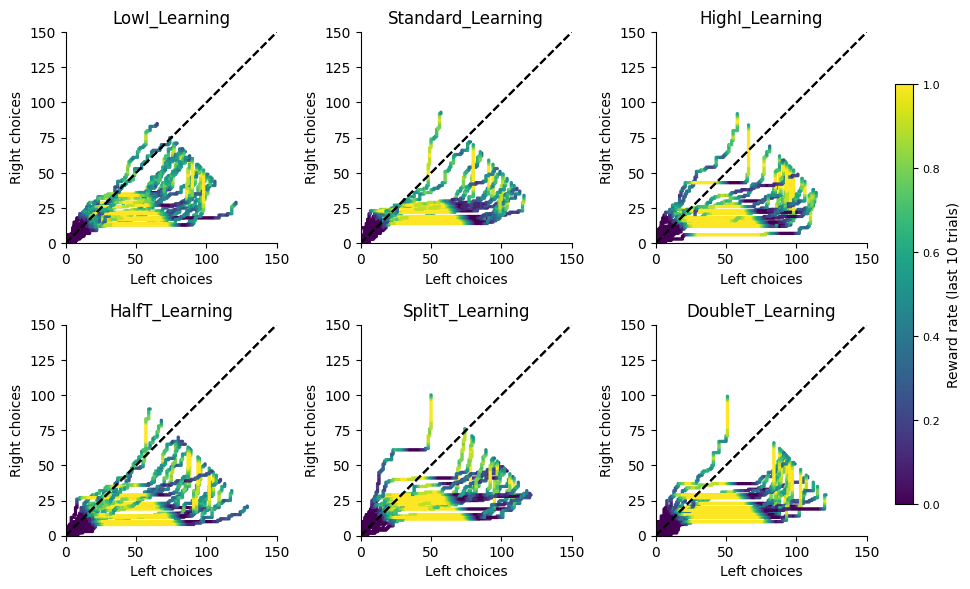

In [24]:
# PLOT CHOICES 

order_map = {
    'DoubleT_Learning.csv':5, 
    'DoubleT_Learning_reciprocal.csv':5,
    'HalfT_Learning.csv':3, 
    'HalfT_Learning_reciprocal.csv':3,
    'HighI_Learning.csv':2,
    'HighI_Learning_reciprocal.csv':2,
    'LowI_Learning.csv':0,
    'LowI_Learning_reciprocal.csv':0,
    'SplitT_Learning.csv':4,
    'SplitT_Learning_reciprocal.csv':4,
    'Standard_Learning.csv':1,
    'Standard_Learning_reciprocal.csv':1
}
cmap = 'viridis'

fig, ax = plt.subplots(2, 3, figsize=(9, 6))
for exp in metadata['Fly Experiment'].sort_values().unique():
    choice_set = choice_data[metadata[metadata['Fly Experiment'] == exp].index]
    reward_set = reward_data[metadata[metadata['Fly Experiment'] == exp].index]
    N_set = choice_set.shape[0]
    for i in range(N_set):
        reward_rate = np.convolve(reward_set[i,:], np.ones(10)/10, mode='same')
        if "_reciprocal" in exp:
            ax.flatten()[order_map[exp]].scatter(np.cumsum(choice_set[i,:]==1), np.cumsum(choice_set[i,:]==0), c=reward_rate, cmap=cmap, s=2, vmin=0, vmax=1)
        else:
            ax.flatten()[order_map[exp]].scatter(np.cumsum(choice_set[i,:]==0), np.cumsum(choice_set[i,:]==1), c=reward_rate, cmap=cmap, s=2, vmin=0, vmax=1)
    ax.flatten()[order_map[exp]].plot([0, choice_set.shape[1]], [0, choice_set.shape[1]], 'k--')
    ax.flatten()[order_map[exp]].set_xlabel('Left choices')
    ax.flatten()[order_map[exp]].set_ylabel('Right choices')
    ax.flatten()[order_map[exp]].set_xlim([0, choice_set.shape[1]])
    ax.flatten()[order_map[exp]].set_ylim([0, choice_set.shape[1]])
    ax.flatten()[order_map[exp]].set_title(exp[:-4].split('_reciprocal')[0])
    ax.flatten()[order_map[exp]].set_aspect('equal')
    ax.flatten()[order_map[exp]].spines['top'].set_visible(False)
    ax.flatten()[order_map[exp]].spines['right'].set_visible(False)

plt.tight_layout()

# add a colorbar to the entire figure
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
cbar = fig.colorbar(ax.flatten()[1].collections[0], cax=cbar_ax, orientation='vertical')
cbar.set_label('Reward rate (last 10 trials)')
cbar.ax.tick_params(labelsize=8)

plt.show()

### Fit Multi-Factor Q-Learning Regression Model

In order to assess the strength of each reward pulse, fit a reinforcement learning model to the data. The best known cognitive model of the data so far is the Q-Learning model with (1) Forgetting, (2) Omission-sensitivity and (3) Softmax Policy Function. 

Q-Learning is a reinforcement learning model that learns the value of each action (choice). Since each trial is identical to the last, this is a single-state model (1-state 2-action Markov Decision Process). In our task, the reward is a flash of light but the strength of the reward depends on the structure of the pulse. The value of each action is updated based on the reward received after the action is taken.

The value of the chosen action is updated using the following equation in experiments with the $i_{th}$ pulse structure:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha_{learn}*(r_t*kappa_i + (1-r_t)*kappa_{omission} - Q_t(a_t))$$

where $Q_{t+1}(a_t)$ is the updated value of the chosen action, $Q_t(a_t)$ is the previous value of the chosen action, $\alpha_{learn}$ is the learning rate, $r_t$ is whether a reward received after the action is taken, $kappa_i$ is the reward strength of the $i_{th}$ pulse structure and $kappa_{omission}$ amount by with the value of the chosen action is increased/decreased when no reward is received.

The value of the unchosen action is updated using the following equation in experiments with the $i_{th}$ pulse structure:

$$Q_{t+1}(a_{t+1}) = (1-\alpha_{forget})*Q_t(a_{t+1})$$

where $Q_{t+1}(a_{t+1})$ is the updated value of the unchosen action, $Q_t(a_{t+1})$ is the previous value of the unchosen action, $\alpha_{forget}$ is the forgetting rate, representing the slow decay of the value of the unchosen action over time.

Since, we can assume that all parameters except the reward strength of the pulse structure are the same for all experiments, we can fit a single model to all the data using a bernoulli regression model. 

The probability of choosing the second odor ($C_t = 1$) is given by the softmax policy function:

$$P(a_t = 1) = softmax(Q_t)_1 = \frac{e^{Q_t(a_t = 1)}}{e^{Q_t(a_t = 0)} + e^{Q_t(a_t = 1)}}$$

where $P(a_t = 0)$ is the probability of choosing the first odor, $Q_t(a_t = 0)$ is the value of the first odor and $Q_t(a_t = 1)$ is the value of the second odor.

We fit the model my minimizing the negative log likelihood of the observed choices ($C_{1:t}$) given the model parameters ($\theta=[\alpha_{learn}, \alpha_{forget}, \kappa_{omission}, \kappa_1, \kappa_2, ..., \kappa_n]$) where $n$ is the number of pulse structures used in the experiment. The likelihood of the observed choices is given by:

$$C_{1:t} \sim Bernoulli(P(a_t = 1)_{1:t})$$
$$P(a_t = 1)_{1:t} = \frac{e^{Q_t(a_t = 1)_{1:t}}}{e^{Q_t(a_t = 0)_{1:t}} + e^{Q_t(a_t = 1)_{1:t}}}$$


where $C_{1:t}$ is the vector of choices made by the fly over trials and $P(a_t = 1)_{1:t}$ is the vector of probabilities of choosing the second odor over trials. The Q-values are updated using the equations above. Starting with $Q_0(a_t = 0) = 0$ and $Q_0(a_t = 1) = 0$.

**This allowes us to identify the relative strength of each pulse structure.**



In [25]:
# FIT MULTIFACTOR OSFQL-MODEL

def fit_ql(params,c,r,e,return_probs=False):
    """
    A function return the probability of choosing odor 2 in a two-odor choice task.
    The choices are made according to a Q-learning rule with forgetting and omission-sensitivity and a softmax policy.
    
    Args:
        params (list): list of parameters (alpha_learn, alpha_forget, kappa_omission, kappa_1, kappa_2, ..., kappa_n)
        c (list): matrix of choices (1 for odor 2, 0 for odor 1) (n_flies x n_trials)
        r (list): matrix of rewards (1 for reward, 0 for no reward) (n_flies x n_trials)
        e (list): matrix of pulse structure identifiers (n_flies x n_trials)
        return_probs (bool): whether to return the probability of choosing odor 2 for each trial (default: False)

    Returns:
        float: negative log-likelihood of the data given the parameters
        np.array: probability of choosing odor 2 for each trial (only if return_probs=True) (n_flies x n_trials)
    """
    liks = [] # list of log-likelihoods
    alpha_learn, alpha_forget, kappa_omission, kappa = params[0], params[1], params[2], params[3:] # unpack parameters
    
    if return_probs: ps = [] # list of probabilities per fly (only if return_probs=True)
    
    for i in range(len(c)):
        # remove nan values
        ct = c[i][~np.isnan(c[i])].copy()
        rt = r[i][~np.isnan(r[i])].copy()
        # initialize q-values
        q = np.zeros(2)

        if return_probs: p = [] # list of probabilities per trial (only if return_probs=True)

        for j in range(len(ct)): # loop over trials
            # use softmax policy
            pval = np.clip(np.exp(q[1])/np.sum(np.exp(q)),1e-6,1-1e-6) # probability of choosing odor 2 (clipped to avoid numerical errors)
            
            if return_probs: p.append(pval) # append probability (only if return_probs=True)

            liks.append(np.log(pval)*ct[j] + np.log(1-pval)*(1-ct[j])) # append log-likelihood using Bernoulli likelihood

            # QLearning Rule
            q[ct[j]] = q[ct[j]] + alpha_learn*((rt[j]*kappa[e[i]]+(1-rt[j])*kappa_omission)-q[ct[j]])
            q[1-ct[j]] = (1-alpha_forget)*q[1-ct[j]]

        if return_probs: 
            temp = np.nan*np.zeros(len(c[i])) # initialize array of probabilities
            temp[~np.isnan(c[i])] = p # fill in array of probabilities
            ps.append(temp) # append array of probabilities (only if return_probs=True)

    return -np.sum(liks) if not return_probs else (-np.sum(liks), np.array(ps))


### Initialize Model Parameters and Process Data

In [26]:
# make a map from unique pulse structure to index
exp_mapper = {exp:i for i, exp in enumerate(metadata['Fly Experiment'].apply(lambda x: x.split('.')[0].split('_reciprocal')[0]).unique())}
# make a map from index to unique pulse structure
exp_mapper_inv = {i:exp.split('_')[0] for i, exp in enumerate(metadata['Fly Experiment'].apply(lambda x: x.split('.')[0].split('_reciprocal')[0]).unique())}

r = reward_data.copy() # rewards
c = choice_data.copy() # choices
e = metadata['Fly Experiment'].apply(lambda x: exp_mapper[x.split('.')[0].split('_reciprocal')[0]]).values # map pulse structure to index

num_e = np.max(e)+1 # number of unique pulse structures
init_params = np.array([0.5,0.5,1]+[1]*num_e) # initial parameters
bounds = [(0,1),(0,1),(0,5)]+[(0,5)]*num_e # bounds for parameters

# create the save directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Optimization techniques

There are many ways to optimize the data. First, we try to find the best parameters using global optimization techniques. Then, we use the best parameters to initialize the optimization process for multiple bootstrap samples of the data to estimate the uncertainty in the parameters.

#### Global Optimization

We use differential evolution to find the best parameters for the model. Differential evolution is a global optimization technique that uses a population of candidate solutions to find the best parameters. The algorithm works by creating a population of candidate solutions and then iteratively updating the population by replacing the worst candidate solutions with new candidate solutions. 

We use a population of 100 candidate solutions and run the algorithm for a maximum of 1000 iterations.

In [27]:
# GLOBAL OPTIMIZATION USING DE from SciPy

go_results = opt.differential_evolution(
    lambda x: fit_ql(x,c,r,e), # objective function
    bounds, # bounds for parameters
    disp=True, # display progress
    maxiter=1000, # maximum number of iterations
    popsize=100 # population size
)

# save results
with open('{}/global_optimization_results.pkl'.format(save_path), 'wb') as f:
    pickle.dump(go_results, f)

In [ ]:
# LOAD RESULTS AND GET BEST PARAMETERS

with open('{}/global_optimization_results.pkl'.format(save_path), 'rb') as f:
    go_results = pickle.load(f)

new_init_params = go_results.x # use best parameters from global optimization as initial parameters

#### Bootstrap Optimization

We use the best parameters from the global optimization to initialize the optimization process for multiple bootstrap samples of the data. Bootstrap samples are created by sampling with replacement from the original data. We take bootstrap samples of the data and run bootstrap optimization using a local optimization technique (L-BFGS-B) for each bootstrap sample.

##### Choosing number of bootstrap samples

In order to choose the number of bootstrap samples, we plot the distribution of the parameters for different number of bootstrap samples. We choose the number of bootstrap samples such that the distribution of the parameters is stable.

In [ ]:
n_boots = [20, 50, 100, 200, 500] # number of bootstrap samples

def opt_func(x,seed):
    """
    A function to optimize the parameters of the OSFQL-model using a bootstrap sample.

    Args:
        x (list): list of parameters (alpha_learn, alpha_forget, kappa_omission, kappa_1, kappa_2, ..., kappa_n)
        seed (int): seed for random number generator
    """
    np.random.seed(seed)
    sample = np.random.choice(np.arange(len(c)),len(c),replace=True)
    return fit_ql(x,c[sample],r[sample],e[sample])

In [ ]:
# BOOTSTRAP OPTIMIZATION USING L-BFGS-B from SciPy
last_means = 100 * np.ones(len(new_init_params)) # initialize array of last means
last_stds = 100 * np.ones(len(new_init_params)) # initialize array of last standard deviations

for n_boot in n_boots:
    print("Fitting {} bootstrap samples".format(n_boot))
    res = Parallel(n_jobs=n_jobs)(delayed(opt.minimize)(opt_func,new_init_params,bounds=bounds,args=(i,),method='L-BFGS-B') for i in tqdm(range(n_boot)))
    # save as pickle
    with open('{}/bootstrap_optimization_results_{}.pkl'.format(save_path,n_boot), 'wb') as f:
        pickle.dump(res, f)

    # get params
    params = np.array([r.x for r in res])

    # get means and standard deviations
    means = np.mean(params,axis=0)
    stds = np.std(params,axis=0)

    # calculate relative change effect size
    rel_change = np.abs(means-last_means)/(last_stds**2+stds**2)**0.5

    # check if converged
    if np.all(rel_change < 0.01):
        print("Converged!")
        break

    # update last means and standard deviations
    last_means = means
    last_stds = stds


In [ ]:
params = np.array([result.x for result in res])

In [ ]:
# plot results using seaborn
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

fig, ax = plt.subplots(1, 2, figsize=(9, 3))

# plot learning rate
sns.distplot(params[:,0], ax=ax[0], kde=False, bins=20)
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Frequency')
ax[0].set_title('QL learning rate')
ax[0].spines['top'].set_visible(False) 
ax[0].spines['right'].set_visible(False)

# plot different reward sensitivities in a boxplot
sns.boxplot(data=params[:,1:], ax=ax[1])
sns.stripplot(data=params[:,1:], ax=ax[1], color='k', alpha=0.5)
# set ticks
ax[1].set_xticks(np.arange(len(exp_mapper_inv)), [exp_mapper_inv[i] for i in np.arange(len(exp_mapper_inv))], rotation=90)


ax[1].set_xlabel('Reward sensitivity')
ax[1].set_ylabel('Value')
ax[1].set_title('QL reward sensitivity')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.show()

In [ ]:
# calculate pairwise effect sizes on reward sensitivity
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# calculate effect sizes
effect_sizes = np.zeros((len(exp_mapper_inv), len(exp_mapper_inv)))
pvals = np.zeros((len(exp_mapper_inv), len(exp_mapper_inv)))
for i in range(len(exp_mapper_inv)):
    for j in range(len(exp_mapper_inv)):
        if i != j:
            t, p = ttest_ind(params[:,i+1], params[:,j+1])
            # correct for multiple comparisons
            p = multipletests([p], method='fdr_bh')[1][0]
            effect_sizes[i,j] = (np.mean(params[:,i+1]) - np.mean(params[:,j+1])) / np.std(params[:,i+1] - params[:,j+1])
            pvals[i,j] = p


# plot effect sizes and p-values
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(effect_sizes, cmap='RdBu_r', center=0, vmin=-1, vmax=1, ax=ax[0], annot=True, fmt='.2f')
ax[0].set_xticklabels(exp_mapper_inv.values(), rotation=90)
ax[0].set_yticklabels(exp_mapper_inv.values(), rotation=0)
ax[0].set_title('Effect sizes')
ax[0].set_xlabel('Experiment')
ax[0].set_ylabel('Experiment')
ax[0].invert_yaxis()

sns.heatmap(pvals_corrected, cmap='RdBu_r', center=0.05,ax=ax[1], annot=True, fmt='.2f')
ax[1].set_xticklabels(exp_mapper_inv.values(), rotation=90)
ax[1].set_yticklabels(exp_mapper_inv.values(), rotation=0)
ax[1].set_title('p-values')
ax[1].set_xlabel('Experiment')
ax[1].set_ylabel('Experiment')
ax[1].invert_yaxis()

plt.tight_layout()

plt.show()


In [ ]:
exp_mapper_inv.values()

In [ ]:
p = fit_ql(res.x,c,r,e,return_probs=True)[1]

In [ ]:
p[metadata[metadata['Fly Experiment'] == exp].index].shape

In [ ]:
def cummean(x):
    return np.cumsum(x)/np.arange(1,len(x)+1)
    
current_exp = ""
for exp in metadata['Fly Experiment'].sort_values().unique():
    if exp[:-4].split('_reciprocal')[0] != current_exp:
        try:
            ax.plot([0, choice_set.shape[1]], [0, choice_set.shape[1]], 'k--')
            ax.set_xlabel('Left choices')
            ax.set_ylabel('Right choices')
            ax.set_xlim([0, choice_set.shape[1]])
            ax.set_ylim([0, choice_set.shape[1]])
            ax.set_title(current_exp)
            ax.set_aspect('equal')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.show()
        except:
            pass
        print(exp[:-4].split('_reciprocal')[0])
        current_exp = exp[:-4].split('_reciprocal')[0]
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    choice_set = p[metadata[metadata['Fly Experiment'] == exp].index]
    reward_set = reward_data[metadata[metadata['Fly Experiment'] == exp].index]
    N_set = choice_set.shape[0]
    for i in range(N_set):
        reward_rate = np.convolve(reward_set[i,:], np.ones(10)/10, mode='same')
        if "_reciprocal" in exp:
            ax.scatter(np.cumsum(choice_set[i,:]), np.cumsum(1-choice_set[i,:]), c=reward_rate, cmap='jet', s=2)
        else:
            ax.scatter(np.cumsum(1-choice_set[i,:]), np.cumsum(choice_set[i,:]), c=reward_rate, cmap='jet', s=2)

ax.plot([0, choice_set.shape[1]], [0, choice_set.shape[1]], 'k--')
ax.set_xlabel('Left choices')
ax.set_ylabel('Right choices')
ax.set_xlim([0, choice_set.shape[1]])
ax.set_ylim([0, choice_set.shape[1]])
ax.set_title(current_exp)
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)